In [3]:
import google.datalab.bigquery as bq
import pandas as pd

# SCHEMA

Table xmdw31:ods_mga.apm_db_os_stat_temp

   Last modified             Schema             Total Rows   Total Bytes   Expiration   Time Partitioning   Labels   kmsKeyName  
 ----------------- --------------------------- ------------ ------------- ------------ ------------------- -------- ------------ 
  24 Jan 08:09:23   |- partition_key: integer   25225288     1009011520                                                          
                    |- db_id: integer                                                                                            
                    |- time: timestamp                                                                                           
                    |- os_id: integer                                                                                            
                    |- max_value: float                                                                                          
                    |- avg_value: float         

# sample

In [20]:
%%bash
bq head -n 5 xmdw31:ods_mga.apm_db_os_stat_temp

+---------------+-------+---------------------+-------+-----------+-----------+
| partition_key | db_id |        time         | os_id | max_value | avg_value |
+---------------+-------+---------------------+-------+-----------+-----------+
|     180117001 |     1 | 2018-01-16 15:03:05 |     0 |      NULL |    3580.0 |
|     180117001 |     1 | 2018-01-16 15:20:39 |     0 |      NULL |      30.0 |
|     180117001 |     1 | 2018-01-16 15:20:45 |     0 |      NULL |       0.0 |
|     180117001 |     1 | 2018-01-16 15:22:13 |     0 |      NULL |    3240.0 |
|     180117001 |     1 | 2018-01-16 15:36:44 |     0 |      NULL |    5630.0 |
+---------------+-------+---------------------+-------+-----------+-----------+


# os_id 의 갯수는 22개이다 0~21

In [60]:
%%bq query 
--name os_num
SELECT os_id
FROM `xmdw31.ods_mga.apm_db_os_stat_temp`
GROUP BY os_id

os_id
0
1
2
3
4
5
6
7
8
9


In [7]:
%%bq query 
--name time_avg_value_os_id_1
SELECT time, avg_value
FROM `xmdw31.ods_mga.apm_db_os_stat_temp`
WHERE os_id = 1
ORDER BY time



max_value데이터는 없는 것으로 확인되었다.

In [59]:
%%bq query 
--name count_max_value
SELECT  COUNT(max_value)
FROM `xmdw31.ods_mga.apm_db_os_stat_temp`
WHERE os_id = 1

f0_
0


# partition_key 가 어떤 것인지 파악해 보기 위해서 조회를 해보고 있다.

In [4]:
%%bq query 
--name count_partition_key
#SQL query to return count_partition_key 
SELECT  os_id, COUNT(partition_key)
FROM `xmdw31.ods_mga.apm_db_os_stat_temp`
GROUP BY os_id
ORDER BY os_id

os_id,f0_
0,1146604
1,1146604
2,1146604
3,1146604
4,1146604
5,1146604
6,1146604
7,1146604
8,1146604
9,1146604


## os_id 에 따라서 1146604개의 partition_key가 있다. 이 숫자와 시간의 분포를 보아야 겠다.

In [11]:
%%bq query 
--name time_partition_key_os_1
SELECT time, os_id, partition_key
FROM `xmdw31.ods_mga.apm_db_os_stat_temp`
ORDER BY time, os_id
LIMIT 100

time,os_id,partition_key
2018-01-05 00:16:14,1,180105001
2018-01-05 00:16:14,19,180105001
2018-01-05 00:16:14,20,180105001
2018-01-05 00:16:14,21,180105001
2018-01-05 00:16:14,17,180105001
2018-01-05 00:16:14,7,180105001
2018-01-05 00:16:14,11,180105001
2018-01-05 00:16:14,9,180105001
2018-01-05 00:16:14,2,180105001
2018-01-05 00:16:14,13,180105001


# 15개의 partition_key 가 있다.

In [29]:
%%bq query
SELECT COUNT(*) AS num_partition_key
FROM(
  SELECT distinct partition_key
  FROM `xmdw31.ods_mga.apm_db_os_stat_temp`
)


num_partition_key
15


## 키들의 종류가 있다. 15개로 180,105,001 로 시작하여 1000씩 증가하면서 180,109,001까지 증가하다가(5개)  180,115,001로 다시 보였다가 180,124,001까지 1000씩 증가한다.(10개)

In [36]:
%%bq query 
SELECT distinct partition_key
FROM `xmdw31.ods_mga.apm_db_os_stat_temp` 
GROUP BY partition_key
ORDER BY partition_key

partition_key
180105001
180106001
180107001
180108001
180109001
180115001
180116001
180117001
180118001
180119001


## 보니 os_id 마다 15개의 partition_key를 가지고 데이터를 수집하고 있다. 따라서 22 * 15 = 330개가 나오는 것이다.

In [42]:
%%bq query 
SELECT distinct partition_key, os_id
FROM `xmdw31.ods_mga.apm_db_os_stat_temp` 
GROUP BY partition_key, os_id
ORDER BY os_id, partition_key

partition_key,os_id
180105001,0
180106001,0
180107001,0
180108001,0
180109001,0
180115001,0
180116001,0
180117001,0
180118001,0
180119001,0


## 180,120,001를 partition_key로 가지고 os_id는 0인 녀석들에 대해서 avg_value를 그래프로 나타내보려고한다.

In [3]:
%%bq query --name p_key_os_id_0_avg_value
SELECT time, avg_value
FROM `xmdw31.ods_mga.apm_db_os_stat_temp` 
WHERE partition_key=180120001 AND os_id=0
ORDER BY time

In [3]:
%%bq sample --query p_key_os_id_0_avg_value

time,avg_value
2018-01-19 15:00:00,1160.0
2018-01-19 15:00:01,80.0
2018-01-19 15:00:02,30.0
2018-01-19 15:00:03,2160.0
2018-01-19 15:00:04,80.0
2018-01-19 15:00:05,30.0
2018-01-19 15:00:06,1520.0
2018-01-19 15:00:07,0.0
2018-01-19 15:00:08,0.0
2018-01-19 15:00:09,2000.0


In [18]:
p_key_os_id_0_avg_value.sql

u'SELECT time, avg_value\nFROM `xmdw31.ods_mga.apm_db_os_stat_temp` \nWHERE partition_key=180120001 AND os_id=0\nORDER BY time'

### 갯수가 86400개인 것을 봐서 60 X 60 X 24 즉 하루였다.

In [12]:
p_key_os_id_0_avg_value = bq.Query(p_key_os_id_0_avg_value.sql)
os_0_avg_df = p_key_os_id_0_avg_value.execute(output_options=bq.QueryOutput.dataframe()).result()
print(os_0_avg_df.head(10))
os_0_avg_df.info()

                 time  avg_value
0 2018-01-19 15:00:00     1160.0
1 2018-01-19 15:00:01       80.0
2 2018-01-19 15:00:02       30.0
3 2018-01-19 15:00:03     2160.0
4 2018-01-19 15:00:04       80.0
5 2018-01-19 15:00:05       30.0
6 2018-01-19 15:00:06     1520.0
7 2018-01-19 15:00:07        0.0
8 2018-01-19 15:00:08        0.0
9 2018-01-19 15:00:09     2000.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86400 entries, 0 to 86399
Data columns (total 2 columns):
time         86400 non-null datetime64[ns]
avg_value    86400 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.3 MB


In [10]:
%%bq query --name p_key_os_id_1_avg_value
SELECT time, avg_value
FROM `xmdw31.ods_mga.apm_db_os_stat_temp` 
WHERE partition_key=180120001 AND os_id=1
ORDER BY time

In [13]:
p_key_os_id_1_avg_value = bq.Query(p_key_os_id_1_avg_value.sql)
os_1_avg_df = p_key_os_id_1_avg_value.execute(output_options=bq.QueryOutput.dataframe()).result()
print(os_1_avg_df.head(10))
os_1_avg_df.info()

                 time  avg_value
0 2018-01-19 15:00:00      410.0
1 2018-01-19 15:00:01      150.0
2 2018-01-19 15:00:02      100.0
3 2018-01-19 15:00:03      690.0
4 2018-01-19 15:00:04       80.0
5 2018-01-19 15:00:05       30.0
6 2018-01-19 15:00:06      450.0
7 2018-01-19 15:00:07       30.0
8 2018-01-19 15:00:08        0.0
9 2018-01-19 15:00:09      780.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86400 entries, 0 to 86399
Data columns (total 2 columns):
time         86400 non-null datetime64[ns]
avg_value    86400 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.3 MB


### os_id마다 partition_key에 따른 값들이 포진해 있다.

In [15]:
%%bq query --name p_key_os_id_0_avg_value_p1
SELECT time, avg_value
FROM `xmdw31.ods_mga.apm_db_os_stat_temp` 
WHERE partition_key=180121001 AND os_id=0
ORDER BY time

In [17]:
p_key_os_id_0_avg_value_p1 = bq.Query(p_key_os_id_0_avg_value_p1.sql)
os_0_avg_p1_df = p_key_os_id_0_avg_value_p1.execute(output_options=bq.QueryOutput.dataframe()).result()
print(os_0_avg_p1_df.head(10))
os_0_avg_p1_df.info()

                 time  avg_value
0 2018-01-20 15:00:00        0.0
1 2018-01-20 15:00:01      100.0
2 2018-01-20 15:00:02     2550.0
3 2018-01-20 15:00:03        0.0
4 2018-01-20 15:00:04       30.0
5 2018-01-20 15:00:05     1630.0
6 2018-01-20 15:00:06        0.0
7 2018-01-20 15:00:07       30.0
8 2018-01-20 15:00:08     2650.0
9 2018-01-20 15:00:09     2530.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86400 entries, 0 to 86399
Data columns (total 2 columns):
time         86400 non-null datetime64[ns]
avg_value    86400 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.3 MB


# partition_key는 그냥 날짜별이라고 생각해도 될 듯 하다. 없는 부분들에 대해서는 빵꾸가 난 것 이다. 결론적으로 단지 avg_value만을 가지고 이상탐지를 할 수 있을 것이다. 또한 데이터 들에 대해서 빵꾸난 것들은 partition_key에 따라서 구분이 되므로 그것들을 묶어서 인덱스에 따른 데이터 프레임을 만들 수 있을 것이다. 또한 이를 이용하여 isolation forest를 만들어내고 할수있을 것이다.

In [1]:
%%bq query --name os_id_0_avg_value_query
SELECT time, avg_value
FROM `xmdw31.ods_mga.apm_db_os_stat_temp`
WHERE os_id=0
ORDER BY time

In [4]:
os_id_0_avg_value_query_df = bq.Query(os_id_0_avg_value_query.sql)
os_id_0_avg_value_df = os_id_0_avg_value_query_df.execute(output_options=bq.QueryOutput.dataframe()).result()
print(os_id_0_avg_value_df.head(10))
os_id_0_avg_value_df.info()

os_id_0_avg_value_df_idxtime = os_id_0_avg_value_df.set_index('time')
print(os_id_0_avg_value_df_idxtime.head(10))
os_id_0_avg_value_df_idxtime.info()

                 time  avg_value
0 2018-01-05 00:16:14        0.0
1 2018-01-05 00:16:15        0.0
2 2018-01-05 00:16:16        0.0
3 2018-01-05 00:16:17        0.0
4 2018-01-05 00:16:18        0.0
5 2018-01-05 00:16:19        0.0
6 2018-01-05 00:16:20        0.0
7 2018-01-05 00:16:21        0.0
8 2018-01-05 00:16:22       30.0
9 2018-01-05 00:16:23        0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1146604 entries, 0 to 1146603
Data columns (total 2 columns):
time         1146604 non-null datetime64[ns]
avg_value    1146604 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 17.5 MB
                     avg_value
time                          
2018-01-05 00:16:14        0.0
2018-01-05 00:16:15        0.0
2018-01-05 00:16:16        0.0
2018-01-05 00:16:17        0.0
2018-01-05 00:16:18        0.0
2018-01-05 00:16:19        0.0
2018-01-05 00:16:20        0.0
2018-01-05 00:16:21        0.0
2018-01-05 00:16:22       30.0
2018-01-05 00:16:23        0.0
<class 'pa

In [7]:
os_id_0_avg_value_df.to_csv('os_id_0_avg_value.csv', sep=',')

In [7]:
os_id_0_avg_value_df_idxtime.index

DatetimeIndex(['2018-01-05 00:16:14', '2018-01-05 00:16:15',
               '2018-01-05 00:16:16', '2018-01-05 00:16:17',
               '2018-01-05 00:16:18', '2018-01-05 00:16:19',
               '2018-01-05 00:16:20', '2018-01-05 00:16:21',
               '2018-01-05 00:16:22', '2018-01-05 00:16:23',
               ...
               '2018-01-23 22:42:28', '2018-01-23 22:42:29',
               '2018-01-23 22:42:30', '2018-01-23 22:42:31',
               '2018-01-23 22:42:32', '2018-01-23 22:42:33',
               '2018-01-23 22:42:34', '2018-01-23 22:42:35',
               '2018-01-23 22:42:36', '2018-01-23 22:42:37'],
              dtype='datetime64[ns]', name=u'time', length=1146604, freq=None)

In [ ]:
os_id_0_avg_value_df_idxtime.loc[:]['avg_value'].plot(kind='barh')

 os_id에 따라서 모든 데이터들을 스토리지에 저장하기 해보자....

In [ ]:
os_id_i_avg_value_query={}
os_id_i_avg_value_df = {}
for i in range(2):
  os_id_i_avg_value_query[i] = bq.Query('SELECT time, avg_value \
                                        FROM `xmdw31.ods_mga.apm_db_os_stat_temp` \
                                        WHERE os_id='+str(i)+' \
                                        ORDER BY time')
  print(os_id_i_avg_value_query[i])
  os_id_i_avg_value_df[i] = os_id_i_avg_value_query[i].execute(output_options=bq.QueryOutput.dataframe()).result()
  print(os_id_i_avg_value_df[i].head(5))

1월 22일 하루의 데이터를 확인해보고자한다.

In [ ]:
os_id_0_avg_value_1_22 = os_id_0_avg_value_df_idxtime.loc['2018-01-22 00:00:00':'2018-01-22 23:59:59']['avg_value'].to_frame()
type(os_id_0_avg_value_1_22)
os_id_0_avg_value_1_22.info()

In [ ]:
%%bq query --os
SELECT distinct partition_key, os_id, time
FROM `xmdw31.ods_mga.apm_db_os_stat_temp` 
GROUP BY partition_key, os_id, time
ORDER BY os_id, time, partition_key
LIMIT 50

In [ ]:
os_id_0_avg_value_query

In [6]:
p_key_time = bq.Query('SELECT time, partition_key \
FROM `xmdw31.ods_mga.apm_db_os_stat_temp` \
WHERE os_id = 1 \
ORDER BY time \
LIMIT 50 \
')
df = p_key_time.execute(output_options=bq.QueryOutput.dataframe()).result()


In [7]:
df.head(10)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
time             50 non-null datetime64[ns]
partition_key    50 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 872.0 bytes


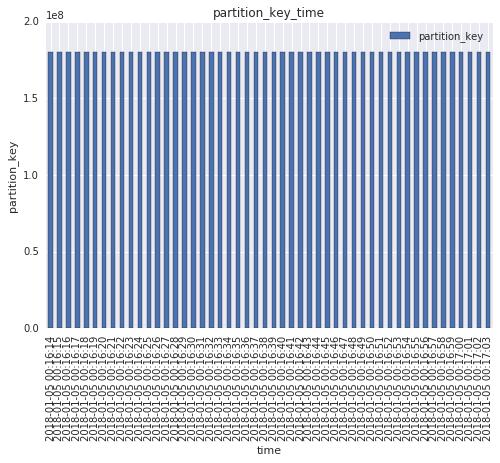

In [10]:
ax = df.plot(kind='bar',x='time',title='partition_key_time')
ax.set_xlabel('time')
ax.set_ylabel('partition_key')

In [52]:
%%bq query --name c_p_key_os_id
SELECT os_id, COUNT(partition_key) as num_p_key
FROM `xmdw31.ods_mga.apm_db_os_stat_temp`
GROUP BY os_id

In [53]:
%%bq sample --query c_p_key_os_id

os_id,num_p_key
0,1146604
1,1146604
2,1146604
3,1146604
4,1146604
5,1146604
6,1146604
7,1146604
8,1146604
9,1146604


In [ ]:
%%bq 

In [ ]:
avg_value_time = bq.Query('SELECT time, avg_value \
FROM `xmdw31.ods_mga.apm_db_os_stat_temp` \
WHERE os_id = 1 \
ORDER BY time')
df = avg_value_time.execute(output_options=bq.QueryOutput.dataframe()).result()
df.head(10)

In [ ]:
ax = df.plot(kind='bar',x='time',title='avg_value_os_id_1')
ax.set_xlabel('Year')
ax.set_ylabel('Birth count')